# 智慧海洋建设-地理数据分析常用工具

## 学习目标
- 了解和学习shapely和geopandas的基本功能，掌握用python中的这两个库实现几何对象之间的空间操作方法。
- 掌握folium和kepler.gl的数据可视化工具的使用。
- 学习与掌握geohash编码方法。

## 学习内容

### shapely

Shapely是python中开源的空间几何对象库，支持Point、Curve和Surface等基本几何对象类型以及相关空间操作 

In [4]:
from shapely import geometry as geo
from shapely import wkt 
from shapely import ops
import numpy as np 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置加载的字体名
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

#### Point

In [20]:
#赋值
point = geo.Point(0.5,0.5)  
point_2 = geo.Point((0,0))  
point_3 = geo.Point(point)
print(list(point.coords))
print(f"point 的x坐标:",point.x,"point 的y坐标:",point.y)

[(0.5, 0.5)]
point 的x坐标: 0.5 point 的y坐标: 0.5


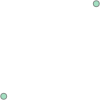

In [21]:
geo.GeometryCollection([point,point_2])#批量进行可视化


In [22]:
print(np.array(point))#可以和np.array进行互相转换

[0.5 0.5]


#### LineStrings  
LineStrings构造函数传入参数是2个或多个点元组

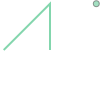

In [38]:
arr=np.array([(0,0), (1,1), (1,0)])
line = geo.LineString(arr) #等同于 line = geo.LineString([(0,0), (1,1), (1,0)]) 
geo.GeometryCollection([line,geo.Point(2,1)])#批量进行可视化


In [37]:
geo.Point(2,1).distance(line)#该方法即可求线线距离也可以求线点距离


1.0

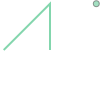

In [40]:
geo.GeometryCollection([line,geo.Point(2,1)])#批量进行可视化

In [41]:
geo.Point(2,1).hausdorff_distance(line)#5**0.5 #该方法求得是点与线的最长距离

2.23606797749979

In [47]:
arr=np.array([(0,0), (1,1), (1,0),(0,0)])
line = geo.LineString(arr) #等同于 line = geo.LineString([(0,0), (1,1), (1,0),(0,0)]) 
line.area

0.0

In [49]:
print('该几何对象的坐标范围:'+str(line.bounds))

该几何对象的坐标范围:(0.0, 0.0, 1.0, 1.0)


In [50]:
print('该几何对象的长度:'+str(line.length))

该几何对象的长度:3.414213562373095


In [51]:
print('该几何对象的几何类型:'+str(line.geom_type))  

该几何对象的几何类型:LineString


In [52]:
print('该几何对象的坐标系:'+str(list(line.coords)))

该几何对象的坐标系:[(0.0, 0.0), (1.0, 1.0), (1.0, 0.0), (0.0, 0.0)]


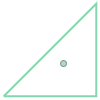

In [53]:
center = line.centroid #几何中心
geo.GeometryCollection([line,center])

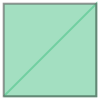

In [54]:
bbox = line.envelope #envelope可以求几何对象的最小外接矩形
geo.GeometryCollection([line,bbox]) 

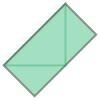

In [55]:
rect = line.minimum_rotated_rectangle #最小旋转外接矩形
geo.GeometryCollection([line,rect])

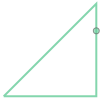

In [60]:
pt_half = line.interpolate(0.5,normalized=True) #插值线段的中点
geo.GeometryCollection([line,pt_half])

In [61]:
ratio = line.project(pt_half,normalized=True) # project()方法是和interpolate方法互逆的
print(ratio)

0.5


下面这个是DouglasPucker算法的应用，在轨迹分析中经常会用得到

In [63]:
line1 = geo.LineString([(0,0),(1,-0.2),(2,0.3),(3,-0.5),(5,0.2),(7,0)])

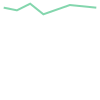

In [64]:
geo.GeometryCollection([line1])

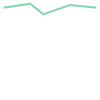

In [65]:
line1.simplify(0.4, preserve_topology=False) 

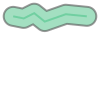

In [70]:
buffer_with_circle = line1.buffer(0.9)  #端点按照半圆扩展
geo.GeometryCollection([line1,buffer_with_circle])

#### LinearRings
LineStrings构造函数传入参数是2个或多个点元组

元组序列可以通过在第一个和最后一个索引中传递相同的值来显式关闭。否则，将第一个元组复制到最后一个索引，从而隐式关闭序列。

与LineString一样，元组序列中的重复点是允许的，但可能会导致性能上的损失，应该避免在序列中设置重复点。

3.414213562373095
0.0


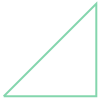

In [74]:
ring = geo.polygon.LinearRing([(0, 0), (1, 1), (1, 0)])
print(ring.length)#相比于刚才的LineString的代码示例，其长度现在是3.41，是因为其序列是闭合的
print(ring.area)
geo.GeometryCollection([ring])

#### Polygon  

Polygon接受两个位置参数，第一个位置参数是和LinearRing一样，是一个有序的point元组。第二个位置参数是可选的序列，其用来指定内部的边界

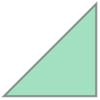

In [85]:
from shapely.geometry import Polygon
polygon1 = Polygon([(0, 0), (1, 1), (1, 0)])
polygon1

In [86]:
polygon1.length

3.414213562373095

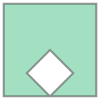

In [90]:
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int_ = [(1, 0), (0.5, 0.5), (1, 1), (1.5, 0.5), (1, 0)]
polygon2 = Polygon(ext, [int_])
polygon2

In [91]:
print(polygon2.area)#其面积是ext的面积减去int的面积
print(polygon2.length)#其长度是ext的长度加上int的长度
print(np.array(polygon2.exterior))

3.5
10.82842712474619
[[0. 0.]
 [0. 2.]
 [2. 2.]
 [2. 0.]
 [0. 0.]]


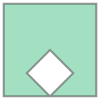

In [92]:
geo.GeometryCollection([polygon2])

#### 几何对象关系

一个几何对象特征分别有interior、boundary和exterior。下面的叙述直接用内部、边界和外部等名词概述

1.object.contains(other)  

如果object的外部没有其他点，或者至少有一个点在该object的内部，则返回True  

a.contains(b)与 b.within(a)的表达是等价的

True


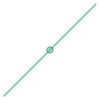

In [97]:
coords = [(0, 0), (1, 1)]
print(geo.LineString(coords).contains(geo.Point(0.5, 0.5)))#线与点的关系
geo.GeometryCollection([geo.LineString(coords),geo.Point(0.5, 0.5)])

False


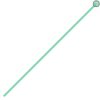

In [98]:
print(geo.LineString(coords).contains(geo.Point(1.0, 1.0)))#因为line的边界不是属于在该对象的内部，所以返回是False
geo.GeometryCollection([geo.LineString(coords),geo.Point(1.0, 1.0)])

True


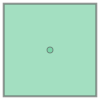

In [101]:
polygon1 = Polygon( [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)])
print(polygon1.contains(geo.Point(1.0, 1.0)))#面与点的关系
geo.GeometryCollection([polygon1,geo.Point(1.0, 1.0)])


3.object.disjoint(other)   
如果该对象与另一个对象的内部和边界都不相交则返回True  
4.object.intersects(other)  
如果该几何对象与另一个几何对象只要相交则返回True。  
5.object.convex_hull  
返回包含对象中所有点的最小凸多边形（凸包）

True


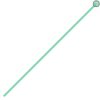

In [103]:
# 2.object.crosses(other)  
# 如果一个object与另一个object是内部相交的关系而不是包含的关系，则返回True  
print( geo.LineString(coords).crosses(geo.LineString([(0, 1), (1, 0)])))
geo.GeometryCollection([ geo.LineString(coords),geo.Point(1.0, 1.0)])

True


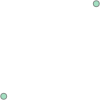

In [104]:
# 3.object.disjoint(other)
# 如果该对象与另一个对象的内部和边界都不相交则返回True
print(geo.Point(0, 0).disjoint(geo.Point(1, 1)))
geo.GeometryCollection([ geo.Point(0, 0),geo.Point(1.0, 1.0)])

True


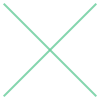

In [106]:
# 4.object.intersects(other)  
# 如果该几何对象与另一个几何对象只要相交则返回True。 
print( geo.LineString(coords).intersects(geo.LineString([(0, 1), (1, 0)])))
geo.GeometryCollection([  geo.LineString(coords),geo.LineString([(0, 1), (1, 0)])])

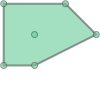

In [107]:
# 在下图中即为在给定6个point之后求其凸包，并绘制出来的凸包图形
points1 = geo.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
hull1 = points1.convex_hull
geo.GeometryCollection([hull1,points1])

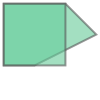

In [114]:
# object.intersection  返回对象与对象之间的交集
polygon1 = Polygon( [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)])
geo.GeometryCollection([hull1,polygon1])


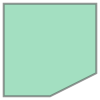

In [115]:
hull1.intersection(polygon1)

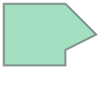

In [109]:
#返回对象与对象之间的并集
hull1.union(polygon1)

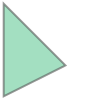

In [116]:
hull1.difference(polygon1) #面面补集

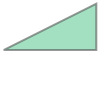

In [117]:
polygon1.difference(hull1) #面面补集

In [118]:
# 6.与numpy和python数组之间的关系
# point、LineRing和LineString提供numpy数组接口，可以进行转换numpy数组
from shapely.geometry import asPoint,asLineString,asMultiPoint,asPolygon
import numpy as np
pa = asPoint(np.array([0.0, 0.0]))#将numpy数组转换成point格式

In [121]:
la = asLineString(np.array([[1.0, 2.0], [3.0, 4.0]]))#将numpy数组转换成LineString格式
ma = asMultiPoint(np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6]]))#将numpy数组转换成multipoint集合
pg = asPolygon(np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6]]))#将numpy数组转换成polygon
print(np.array(pa))#将Point转换成numpy格式

[0. 0.]


另外还有一些非常有用但是不属于某个类方法的函数，如有需要可以在官网查阅
- ops.nearest_points 求最近点
- ops.split 分割线
- ops.substring  求子串
- affinity.rotate 旋转几何体
- affinity.scale 缩放几何体
- affinity.translate 平移几何体

## [geopandas](https://geopandas.org/)
GeoPandas提供了地理空间数据的高级接口，它让使用python处理地理空间数据变得更容易。GeoPandas扩展了pandas使用的数据类型，允许对几何类型进行空间操作。几何运算由shapely执行。Geopandas进一步依赖fiona进行文件访问，依赖matplotlib进行绘图。

geopandas和pandas一样，一共有两种数据类型：
- GeoSeries
- GeoDataFrame
它们继承了pandas数据结构的大部分方法。这两个数据结构可以当做地理空间数据的存储器，shapefile文件的pandas呈现。  

Shapefile文件用于描述几何体对象：点，折线与多边形。例如，Shapefile文件可以存储井、河流、湖泊等空间对象的几何位置。除了几何位置，shp文件也可以存储这些空间对象的属性，例如一条河流的名字，一个城市的温度等等。

例如，当安装geopandas库后，便可通过matplotlib直接画出当安装geopandas数据集中的世界地图

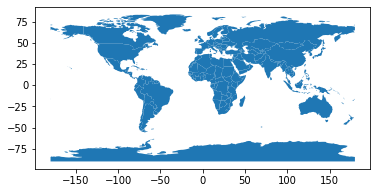

In [123]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#read_file方法可以读取shape文件，转化为GeoSeries和GeoDataFrame数据类型。
world.plot()#将GeoDataFrame变成图形展示出来，得到世界地图
plt.show()

In [124]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


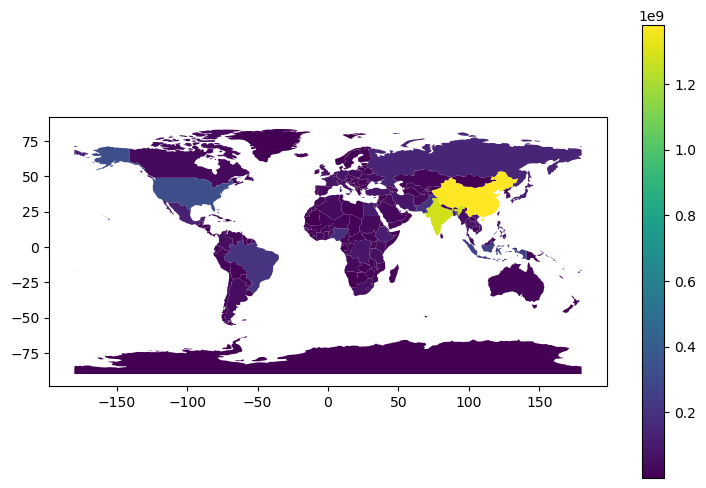

In [125]:
#根据每一个polygon的pop_est不同，便可以用python绘制图表显示不同国家的人数
fig, ax = plt.subplots(figsize=(9,6),dpi = 100)
world.plot('pop_est',ax = ax,legend = True)
plt.show()

由以上geodataframe的实例world可知，其最后一列是geometry。其几何对象包括了MULTIPOLYGON 、POLYGON，那么便同样可以用刚才介绍的shapely库进行分析。



## Folium
[官方文档](https://python-visualization.github.io/folium/index.html)



In [ ]:
'''
folium可以满足我们平时常用的热力图、填充地图、路径图、散点标记等高频可视化场景.folium也可以通过flask让地图和我们的数据在网页上显示，极其便利。

【Folium map参数】
location: tuple:或st类型输入,用于控制初始地图中心点的坐标,格式为(纬度,经度)或[纬度,经度],默认为None
width:int型或st型,int型时,传入的是地图宽度的素值;str型时,传入的是地图宽度的百分比,形式为xx%。默认为100%
height:控制地图的高度,格式同 width
titles:str型,用于控制绘图调用的地图样式,默认为 OpenStreetMap,也有一些其他的内建地图样式,如 Stamen Terrain、Stamen Toner
Mapbox Bright、 Mapbox Control Room 等;也可以传入None来绘制一个没有风格的朴素地图,或传入一个URl来使用其它的自选osm
max_zoom:int型,控制地图可以放大程度的上限,默认为18
attr:str型,当在tes中使用自选UR内的osm时使用,用于给自选osm命名
control_scale:bool型,控制是否在地图上添加例尺,默认为 False即不添加
no_touch:bool型,控制地图是否禁止接受来设备的触控事件警如拖拽等,默认为False,即不禁止
'''


In [130]:
import folium
import os
#首先，创建一张指定中心坐标的地图，这里将其中心坐标设置为北京。
# zoom_start表示初始地图的缩放尺寸，数值越大放大程度越大
m=folium.Map(location=[39.9,116.4],zoom_start=10)
m

用Folium绘制热力图示例

In [131]:
import folium
import numpy as np
from folium.plugins import HeatMap
#先手动生成data数据，该数据格式由[纬度，经度，数值]构成
data=(np.random.normal(size=(100,3))*np.array([[1,1,1]])+np.array([[48,5,1]])).tolist()
# data

In [132]:
m=folium.Map([48,5],tiles='stamentoner',zoom_start=6)
HeatMap(data).add_to(m)
m 

folium的其他使用可以参考知乎的这篇文章，较为全面。  
https://www.zhihu.com/question/33783546

## Kepler.gl  

[kepler.gl基础教程](https://sspai.com/post/55655)

[Python各坐标系之间的转换(高斯、WGS84、Web墨卡托、瓦片坐标)](https://blog.csdn.net/u010410697/article/details/106987747?utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-4.control&dist_request_id=1331302.7854.16182775454210789&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromMachineLearnPai2%7Edefault-4.control)

Kepler.gl与folium类似，也是是一个图形化的数据可视化工具，基于Uber的大数据可视化开源项目deck.gl创建的demo app。目前支持3种数据格式：CSV、JSON、GeoJSON。

Kepler.gl官网提供了可视化图形案例，分别是Arc（弧）、Line（线）、Hexagon（六边形）、Point（点）、Heatmap（等高线图）、GeoJSON、Buildings（建筑）。

In [134]:
import pandas as pd 
import geopandas as gpd
from pyproj import Proj 
from keplergl import KeplerGl
from tqdm import tqdm
import os 
import matplotlib.pyplot as plt
import shapely
import numpy as np
from datetime import datetime  
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['kaiti']    # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False      # 解决保存图像时 负号'-' 显示为方块和报错的问题。

In [135]:
#获取文件夹中的数据
def get_data(file_path,model):
    assert model in ['train', 'test'], '{} Not Support this type of file'.format(model)
    paths = os.listdir(file_path)
    print(len(paths))
    tmp = []
    for t in  tqdm(range(len(paths))):
        p = paths[t]
        with open('{}/{}'.format(file_path, p), encoding='utf-8') as f:
            next(f)
            for line in f.readlines():
                tmp.append(line.strip().split(','))
    tmp_df = pd.DataFrame(tmp)
    if model == 'train':
        tmp_df.columns = ['ID', 'lat', 'lon', 'speed', 'direction', 'time', 'type']
    else:
        tmp_df['type'] = 'unknown'
        tmp_df.columns = ['ID', 'lat', 'lon', 'speed', 'direction', 'time', 'type']
    tmp_df['lat'] = tmp_df['lat'].astype(float)
    tmp_df['lon'] = tmp_df['lon'].astype(float)
    tmp_df['speed'] = tmp_df['speed'].astype(float)
    tmp_df['direction'] = tmp_df['direction'].astype(float)
    tmp_df = tmp_df.convert_dtypes()
#     tmp_df['direction'] = tmp_df['direction'].astype(int)#如果该行代码运行失败，请尝试更新pandas的版本
    return tmp_df
# 平面坐标转经纬度，供初赛数据使用
# 选择标准为NAD83 / California zone 6 (ftUS) (EPSG:2230)，查询链接：https://mygeodata.cloud/cs2cs/
def transform_xy2lonlat(df):
    '''
    format ='+proj=lcc +lat_0=0 +lon_0=117 +k=1+z_0=500000 +y_0=0 +ellps=VGS84 +units=m +no_defs' 
    +proj= name:这是经常必选的一个地图投影转换函数。Name是一个投影名称
    +lon 0=c:设置中央经线。通常和+lat_0,一起决定投影的地理起点
    +lat O=d:设置纬度起点。通常和+lon_0,一起决定投影的地理起点
    +k:比例系数(比例因子)
    +x_0=x0:设置假东，例如在gauss - kruge中，东偏500000米。主要用来保持坐标的非负
    +y_0=y0:设置假北，主要用来保持坐标非负
    +ellps=acronym:选择一个proj里的椭球体。Acronym为椭球体名
    +units=name:设置地图坐标的单位
    +no defs:不要使用proj库中的缺省定义文件
    '''
    format_ = '+proj=lcc +lat_1=33.88333333333333 +lat_2=32.78333333333333 +lat_0=32.16666666666666 +lon_0=-116.25 +x_0=2000000.0001016 +y_0=500000.0001016001 +datum=NAD83 +units=us-ft +no_defs '
    x = df['lat'].values
    y = df['lon'].values
    p=Proj(format_)
    df['lon'], df['lat'] = p(y, x, inverse=True)
    return df  

#修改数据的时间格式
def reformat_strtime(time_str=None, START_YEAR="2019"):
    """Reformat the strtime with the form '08 14' to 'START_YEAR-08-14' """
    time_str_split = time_str.split(" ")
    time_str_reformat = START_YEAR + "-" + time_str_split[0][:2] + "-" + time_str_split[0][2:4]
    time_str_reformat = time_str_reformat + " " + time_str_split[1]
#     time_reformat=datetime.strptime(time_str_reformat,'%Y-%m-%d %H:%M:%S')
    return time_str_reformat
#计算两个点的距离
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 1000

def compute_traj_diff_time_distance(traj=None):
    """Compute the sampling time and the coordinate distance."""
    # 计算时间的差值
    time_diff_array = (traj["time"].iloc[1:].reset_index(drop=True) - traj[
        "time"].iloc[:-1].reset_index(drop=True)).dt.total_seconds() / 60

    # 计算坐标之间的距离
    dist_diff_array = haversine_np(traj["lon"].values[1:],  # lon_0
                                   traj["lat"].values[1:],  # lat_0
                                   traj["lon"].values[:-1], # lon_1
                                   traj["lat"].values[:-1]  # lat_1
                                   )

    # 填充第一个值
    time_diff_array = [time_diff_array.mean()] + time_diff_array.tolist()
    dist_diff_array = [dist_diff_array.mean()] + dist_diff_array.tolist()
    traj.loc[list(traj.index),'time_array'] = time_diff_array
    traj.loc[list(traj.index),'dist_array'] = dist_diff_array
    return traj 

#对轨迹进行异常点的剔除
def assign_traj_anomaly_points_nan(traj=None, speed_maximum=23,
                                   time_interval_maximum=200,
                                   coord_speed_maximum=700):
    """Assign the anomaly points in traj to np.nan."""
    def thigma_data(data_y,n): 
        data_x =[i for i in range(len(data_y))]
        ymean = np.mean(data_y)
        ystd = np.std(data_y)
        threshold1 = ymean - n * ystd
        threshold2 = ymean + n * ystd
        judge=[]
        for data in data_y:
            if (data < threshold1)|(data> threshold2):
                judge.append(True)
            else:
                judge.append(False)
        return judge
    # Step 1: The speed anomaly repairing
    is_speed_anomaly = (traj["speed"] > speed_maximum) | (traj["speed"] < 0)
    traj["speed"][is_speed_anomaly] = np.nan

    # Step 2: 根据距离和时间计算速度
    is_anomaly = np.array([False] * len(traj))
    traj["coord_speed"] = traj["dist_array"] / traj["time_array"]
    
    # Condition 1: 根据3-sigma算法剔除coord speed以及较大时间间隔的点
    is_anomaly_tmp = pd.Series(thigma_data(traj["time_array"],3)) | pd.Series(thigma_data(traj["coord_speed"],3))
    is_anomaly = is_anomaly | is_anomaly_tmp
    is_anomaly.index=traj.index
    # Condition 2: 轨迹点的3-sigma异常处理
    traj = traj[~is_anomaly].reset_index(drop=True)
    is_anomaly = np.array([False] * len(traj))

    if len(traj) != 0:
        lon_std, lon_mean = traj["lon"].std(), traj["lon"].mean()
        lat_std, lat_mean = traj["lat"].std(), traj["lat"].mean()
        lon_low, lon_high = lon_mean - 3 * lon_std, lon_mean + 3 * lon_std
        lat_low, lat_high = lat_mean - 3 * lat_std, lat_mean + 3 * lat_std

        is_anomaly = is_anomaly | (traj["lon"] > lon_high) | ((traj["lon"] < lon_low))
        is_anomaly = is_anomaly | (traj["lat"] > lat_high) | ((traj["lat"] < lat_low))
        traj = traj[~is_anomaly].reset_index(drop=True)
    return traj, [len(is_speed_anomaly) - len(traj)]

In [136]:
df=get_data(r'./data/hy_round1_train_20200102/','train')

  0%|          | 0/7000 [00:00<?, ?it/s]

7000


100%|██████████| 7000/7000 [00:30<00:00, 231.31it/s]


In [137]:
df=transform_xy2lonlat(df)
df['time']=df['time'].apply(reformat_strtime)
df['time']=df['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [270]:
#读取github的数据
DF=pd.read_csv('./data/DF.csv')

DF[:10]

,Unnamed: 0,ID,lat,lon,speed,direction,time,type,time_array,dist_array,coord_speed
0,0,4924,44.878993,-121.048498,0.38,103,2019-11-13 23:59:30,围网,-1.088487,19.788529,-18.179848
1,1,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:58:27,围网,-1.050000,0.000000,-0.000000
2,2,4924,44.878993,-121.048498,0.00,0,2019-11-13 23:57:24,围网,-1.050000,0.000000,-0.000000
3,3,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:56:20,围网,-1.066667,0.000000,-0.000000
4,4,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:55:17,围网,-1.050000,0.000000,-0.000000
5,5,4924,44.878993,-121.048498,0.38,55,2019-11-13 23:54:14,围网,-1.050000,0.000000,-0.000000
6,6,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:53:11,围网,-1.050000,0.000000,-0.000000
7,7,4924,44.878993,-121.048498,0.16,0,2019-11-13 23:52:07,围网,-1.066667,0.000000,-0.000000
8,8,4924,44.878993,-121.048498,0.16,0,2019-11-13 23:51:04,围网,-1.050000,0.000000,-0.000000
9,9,4924,44.878993,-121.048498,0.27,322,2019-11-13 23:50:01,围网,-1.050000,0.000000,-0.000000


化简前数据长度：402
化简后数据长度：49


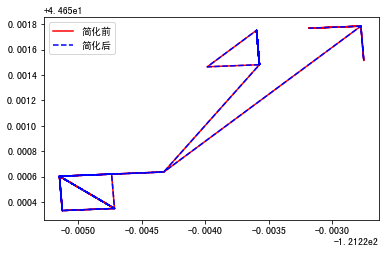

In [216]:
#douglas-peucker案例，由该案例可以看出针对相同ID的轨迹，可以先用geopandas将其进行简化和数据压缩
line= shapely.geometry.LineString(np.array(df[df['ID']=='14'][['lon','lat']]))
ax=gpd.GeoSeries([line]).plot(color='red')
ax = gpd.GeoSeries([line]).simplify(tolerance=0.000000001).plot(color='blue', 
                                                        ax=ax,
                                                        linestyle='--')
LegendElement = [plt.Line2D([], [], color='red', label='简化前'),
                 plt.Line2D([], [], color='blue', linestyle='--', label='简化后')]

# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend(handles = LegendElement, 
          loc='upper left', 
          fontsize=10)
# ax.set_ylim((-2.1, 1))
# ax.axis('off')
print('化简前数据长度：'+str(len(np.array(gpd.GeoSeries([line])[0]))))
print('化简后数据长度：'+str(len(np.array(gpd.GeoSeries([line]).simplify(tolerance=0.000000001)[0]))))

In [140]:
#定义数据简化函数。即通过shapely库将经纬度转换成LineString格式
#然后放入GeoSeries数据结构中并进行简化，最后再将所有数据放入GeoDataFrame中
# df_gpd_change.pkl是将异常处理之后的数据进行douglas-peucker算法进行压缩之后的数据。该数据已经放到了github上面给出的附件数据里面
df_gpd_change=pd.read_csv('./data/df_gpd_change.csv')

In [153]:
from keplergl import KeplerGl
map_2 = KeplerGl(height=400, data={"data_1": df_gpd_change})
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':         ID type                                           geometry
0        0   拖网  L…

通过kepler.gl的数据可视化便可以看出不同类别的轨迹所在的位置有所不同，而且其不同船舶轨迹的形状特征也可以显示出来。

算完之后将数据重新化为dataframe格式，然后可以去计算geohash作为每一条船的数据特征

另外，kepler.gl最近新增「增量时间窗口」功能功能对时间序列数据的可视化提供了很好的帮助。当我们的数据集带有时间类型字段时，在添加对应的Filters之后，显示出的时间窗口如下图所示

## GeoHash

参考文献：https://blog.csdn.net/zhufenghao/article/details/85568340

https://www.jianshu.com/p/2fd0cf12e5ba

在对于经纬度进行数据分析和特征提取时常用到的是GeoHash编码，该编码方式可以将地理经纬度坐标编码为由字母和数字所构成的短字符串，它具有如下特性：

层级空间数据结构，将地理位置用矩形网格划分，同一网格内地理编码相同

只要编码长度足够长，可以表示任意精度的地理位置坐标

编码前缀匹配的越长，地理位置越邻近。

那么GeoHash算法是怎么对经纬度坐标进行编码的呢？

总的来说，它采用的是二分法不断缩小经度和纬度的区间来进行二进制编码，

最后将经纬度分别产生的编码奇偶位交叉合并，再用字母数字表示。

举例来说，对于一个坐标116.29513,40.04920的经度执行算法：

-. 将地球经度区间[-180,180]二分为[-180,0]和[0,180]，116.29513在右区间，记1；
-. 将[0,180]二分为[0,90]和[90,180]，116.29513在右区间，记1；
-. 将[90,180]二分为[90,135]和[135,180]，116.29513在左区间，记0；
-. 递归上述过程（左区间记0，右区间记1）直到所需要的精度，得到一串二进制编码11010 01010 11001。

同理将地球纬度区间[-90,90]根据纬度40.04920进行递归二分得到二进制编码10111 00011 11010，

接着生成新的二进制数，它的偶数位放经度，奇数位放纬度，得到11100 11101 00100 01101 11110 00110，

最后使用32个数字和字母（字母去掉a、i、l、o这4个）进行32进制编码，即先将二进制数每5位转化为十进制28 29 4 13 30 6，然后对应着编码表进行映射得到wy4ey6。

In [146]:
# reference: https://github.com/vinsci/geohash
def geohash_encode(latitude, longitude, precision=12):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

In [147]:
#调用Geohash函数
DF[DF['ID']==1].apply(lambda x: geohash_encode(x['lat'], x['lon'], 7), axis=1)

1873158    9rc76bv
1873159    9rc76cq
1873160    9rc76fw
1873161    9rc76gn
1873162    9rc76gy
            ...   
1873517    9rc7xnv
1873518    9rc7xnv
1873519    9rc7xnv
1873520    9rc7xnv
1873521    9rc7xnv
Length: 364, dtype: object

## 作业

基础作业：  
1.尝试去使用kepler.gl可视化来分析不同类型船舶AIS数据的分布情况，并为接下来的特征工程的提取建立基础  
进阶作业：   


2.在这个模块中，我们介绍了各种库以及他们常用的方法。如果可以，请同学们尝试在原有剔除异常点的数据（DF）中保留douglas-peucker算法所识别的关键点的数据，删除douglas-peucker未保存的数据，并尝试对这些坐标点进行geohash编码

In [160]:
DF=pd.read_csv('./data/DF.csv')#对轨迹进行异常点剔除，对nan值进行线性插值a
DF['ID'] = DF['ID'].astype('str')

In [276]:
from joblib import Parallel, delayed
def get_df_tmp1(DF,ID_tmp):
    df_tmp1 = pd.DataFrame() 
    tmp_ID_lon_lat = np.array(DF[DF['ID']==ID_tmp][['lon','lat']])
    tmp_ID_lon_lat_line = shapely.geometry.LineString(tmp_ID_lon_lat)
    tmp_ID_lon_lat_line_dp = gpd.GeoSeries(tmp_ID_lon_lat_line).simplify(tolerance=0.000000001)[0]
    df_tmp1['aa'] = list(np.array(tmp_ID_lon_lat_line_dp))
    df_tmp1['lon'] = df_tmp1['aa'].apply(lambda x:x[0])
    df_tmp1['lat'] = df_tmp1['aa'].apply(lambda x:x[1])
    df_tmp1['ID'] =ID_tmp
    df_tmp1['geohash'] = df_tmp1.apply(lambda x: geohash_encode(x['lat'], x['lon'], 7), axis=1)
    return df_tmp1
df_tmp1_list = Parallel(n_jobs=1)(delayed(get_df_tmp1)(DF,ID_tmp) for ID_tmp in list(DF['ID'].unique()[:2])) 
df_tmp1 = pd.concat(df_tmp1_list,axis = 0,ignore_index= True)
df_tmp1


,aa,lon,lat,ID,geohash
0,"[-121.0484981838795, 44.878993087045735]",-121.048498,44.878993,4924,9rczm3z
1,"[-121.03668419055069, 44.905622010300206]",-121.036684,44.905622,4924,9rczmwz
2,"[-121.03632659361841, 44.90644502921925]",-121.036327,44.906445,4924,9rczmyb
3,"[-121.03638249024719, 44.907253831534774]",-121.036382,44.907254,4924,9rczmxp
4,"[-121.03641973636059, 44.90779303235588]",-121.036420,44.907793,4924,9rczmxp
...,...,...,...,...,...
4530,"[-122.09982639615696, 44.136307525013116]",-122.099826,44.136308,4069,9rc5jdc
4531,"[-122.0997606823429, 44.135756873333264]",-122.099761,44.135757,4069,9rc5jd9
4532,"[-122.09972782007613, 44.13548154766329]",-122.099728,44.135482,4069,9rc5jd9
4533,"[-122.09929028163748, 44.13522852071724]",-122.099290,44.135229,4069,9rc5jdd
